In [2]:
import torch
import pyro
import pyro.distributions as dist
from torch.distributions import constraints
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pyro.set_rng_seed(101)
torch.manual_seed(101)
torch.set_printoptions(precision=3)
%matplotlib inline

## 1. Intro to Pyro

Pyro is a universal probabilistic programming language (PPL) written in Python and supported by PyTorch on the backend. It enables flexible and expressive deep probabilistic modeling, unifying the best of modern deep learning and Bayesian modeling.

### 1.2 Models and Probability distributions
**Models** are the basic unit of probabilistic programs in pyro, they represent simplified or abstract descriptions of a process by which data are generated. Models in pyro are expressed as *stochastic functions* which implies that models can be composed, reused, imported, and serialized just like regular Python callables. **Probability distributions** (pimitive stochastic functions) are important class of models (stochastic functions) used explicitly to compute the probability of the outputs given the inputs.  Pyro uses [PyTorch’s distribution library](https://pytorch.org/docs/master/distributions.html) which contains parameterizable probability distributions and sampling functions. This allows the construction of stochastic computation graphs and stochastic gradient estimators for optimization. Each probability distributions are equipped with several  methods such as:

* **prob()**: $\log p(\mathbf{x} \mid \theta ^{*})$
* **mean**: $\mathbb{E}_{p(\mathbf{x} \mid \theta ^{*})}[\mathbf{x}]$
* **sample**: $\mathbf{x}^{*} \sim  {p(\mathbf{x} \mid \theta ^{*})}$


You can also create custom distributions using [transforms](https://pytorch.org/docs/master/distributions.html#module-torch.distributions.transforms).


**Example 1**: Let define the unit normal distribution $\mathcal{N}(0,1)$, draw  sample $x$ and  compute the log probability according to the distribution.

In [3]:
mu = 0  
sigma = 1 
normal=dist.Normal(mu, sigma) 
x = normal.rsample() # draw a sample from N(1,1)
print("sample", x.item())
#To compute the log probability according to the distribution
print("prob", torch.exp(normal.log_prob(x)).item()) # score the sample from N(1,1)

sample -1.3905061483383179
prob 0.15172401070594788


### 1.3 Sample and Param statements
Pyro simplifies the process of sampling from distributions with the use of  **pyro.sample** statement. The **pyro.sample** statement  call stochastic functions or models with a *unique name* as identifier. Pyro’s backend uses these names to uniquely identify sample statements and change their behavior at runtime depending on how the enclosing stochastic function is being used. Using **pyro.sample** statement, Pyro can implement  various manipulations that underlie inference algorithms.

```python
x = pyro.sample("name", fn, obs)

"""
name – name of sample
fn – distribution class or function
obs – observed datum (optional; should only be used in context of inference) optionally specified in kwargs
"""
```
**Example 2**: Let sample from previous normal distribution created in example 1.

In [4]:
mu = 0  
sigma = 1 
x = pyro.sample("my_sample", dist.Normal(mu, sigma))
print(x)

tensor(-0.815)


The above code generate a random value and records it in the Pyro runtime.

In [5]:
data=2
x = pyro.sample("my_sample", dist.Normal(mu, sigma), obs=data)
print(x)

c:\users\joanna\miniconda3\lib\site-packages\pyro\primitives.py:86: RuntimeWarning: trying to observe a value outside of inference at my_sample
  RuntimeWarning)


2


The above code conditions a stochatsic function on observed data. This should run on inference.

Pyro use  **pyro.param** statement to  saves the variable as a parameter in the param store. To interact with the param store. The **pyro.param** statement is used by pyro to  declares a learnable parameter.


```python
x = pyro.param("name", init_value, constraints)

"""
name – name of param
init_value – initial value
constraint – torch constraint
"""
```
**Example 3**: Let create theta parameter

In [6]:
theta = pyro.param("theta", torch.tensor(1.0), constraint=dist.constraints.positive)

## Simple model

### Regression model
\begin{align}
y(t) &\sim \lambda \exp(-\lambda)\\
\lambda &\sim \exp(c + m(t))\\
c &\sim \mathcal{N}(1, 1)\\
m &\sim \mathcal{N}(0, 1)
\end{align}



In [43]:
def model(y):
    slope = pyro.sample("slope", dist.Normal(0, 0.1))
    intercept = pyro.sample("intercept", dist.Normal(1, 1))
    for t in range(len(y)):
        rate = torch.exp(intercept + slope * t)
        y[t] = pyro.sample("count_{}".format(t), dist.Poisson(rate),
                                obs=y[t])
    return slope, intercept, y

In [56]:
def traffic_model(y):
    sigma = 1.0
    eps = 1.
    prev_theta = pyro.param('initial_theta', torch.tensor(1.))
    for t in range(len(y)):
        theta = pyro.sample('theta', dist.Normal(prev_theta, eps))
        y[t] = pyro.sample('x', dist.Normal(theta, sigma), obs=y[t])
        prev_theta = theta
    return prev_theta, y

Given a pyro model.
We can
1. **Generate data from model**
2. **Learn parameters of the model from data**
3. **Use the model to predict future observation**.

To generate data from model defined  above

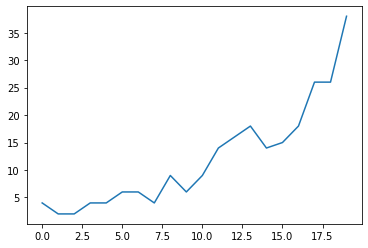

In [44]:
pyro.set_rng_seed(0)
# We pass counts = [None, ..., None] to indicate time duration.
true_slope, true_intercept, true_counts = model([None] * 20)
fig, ax =  plt.subplots(figsize=(6,4))
ax = sns.lineplot(x=np.arange(len(true_counts)),y=[c.item() for c in true_counts])

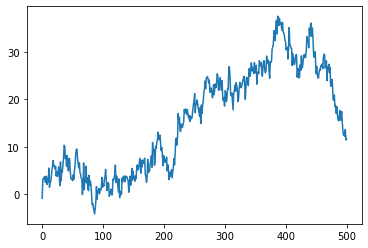

In [57]:
theta, traffic = traffic_model([None] * 500)
fig, ax =  plt.subplots(figsize=(6,4))
ax = sns.lineplot(x=np.arange(len(traffic)),y=[c.item() for c in traffic])

### 1.3 Learn parameters of the model from data

To learn model parameters we pass the model to an inference algorithm and let the algorithm guess what the model is doing based on observed data.



The guide is a stochastic function that represents a probability distribution over the latent (unobserved) variables. The guide can be arbitrary python code just like the model, but with a few requirements:
- Every pyro.sample statement without the obs keyword that appears in the model must have a corresponding pyro.sample statement with the same name in the guide. We sample with the name pay_probs here
- There are no pyro.sample statements with the obs keyword in the guide. These are exclusive to the model.
- There are pyro.param statements, which are exclusive to the guide. These provide differentiation for the inputs to the pay_probs sample in the guide vs. the model. 


We will use Autoguide pyro inference algorithm:
- AutoLaplaceApproximation:Laplace approximation (quadratic approximation) approximates the posterior log𝑝(𝑧|𝑥) by a multivariate normal distribution in the unconstrained space.
- Autodelta: This implementation of AutoGuide uses Delta distributions to construct a MAP guide over the entire latent space. 